In [32]:
import json
import pandas as pd
import glob
import os
import re
import numpy as np

In [33]:
##### load Odin extractions #####

combined_ie = pd.read_csv("combined_data_ie_label.csv")
ie_extraction = combined_ie[['message_id', 'participant', 'start_timestamp', 'end_timestamp', 'ie_extraction']]
ie_extraction.set_index("message_id", inplace=True)

In [34]:
len(ie_extraction)

6727

In [36]:
####### Read in annotation ######

def readAnn(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0).\
        fillna("NA")\
        [["message_id", "Label", "Score", "Category", "Note"]]
    # exclude pre-game and post-game lines
    data = dataAll_df[dataAll_df["Note"] == "NA"]\
                [["message_id", "Label", "Score", "Category"]]
    return data

In [37]:
dir_csv = glob.glob(os.path.join("CLC_annotation_MultiCat", 
                                "*.csv"))
dir_csv.sort()

dfs = (readAnn(dir) for dir in dir_csv)
ann_df = pd.concat(dfs, ignore_index=True)
ann_df.set_index("message_id", inplace=True)

In [38]:
len(ann_df)

6542

In [39]:
# match the message_id in ie_extraction with ann_df 
# to include only the annotated utterances

# select items in message_id which index appears in ann_df
ie_extraction = ie_extraction[ie_extraction.index.isin(ann_df.index)]
ie_extraction = ie_extraction[~ie_extraction.index.duplicated(keep='first')]
ann_df = ann_df[ann_df.index.isin(ie_extraction.index)]

# reset index
ie_extraction.reset_index(inplace=True)
ann_df.reset_index(inplace=True)


In [40]:
len(ann_df)

4929

In [41]:
# convert the dataframe to iterable list
list_ie_data = ie_extraction.values.tolist()

# read callout, checkback, and closing labelset
with open('label_selection.json', 'r') as file:
    label_selection = json.load(file)
callout_selection = label_selection["callout_selection"]
checkback_selection = label_selection["checkback_selection"]
closing_selection = label_selection["closing_selection"]

In [42]:
######## CLC extraction #######

def extract_clc(list_ie_data, win_size):
    '''This function takes the nested list of the data (message_id, participant, ie_extraction),
    and output the extracted clc event 
    eg.{turn_1:{message_id: 'a'}, turn_2:{message_id:'a', message_id:'b'}'''

    # Create a dict to store the clc extraction
    clc_extraction = {}

    for n in range(len(list_ie_data) - win_size):
        # Get the n:n+win_size window
        window = list_ie_data[n : n + win_size]
        
        # Find a
        message_id, participant, start, end, ie_extraction = list_ie_data[n]
        if not start == start: start = end
        is_a = False
        if ie_extraction == ie_extraction:
            for label in ie_extraction.split(', '):
                if label in callout_selection:
                    is_a = True
        if is_a:
            clc_extraction[n] = {message_id: 'a'}
            # Find b
            for item in window[1:]:
                next_id, next_participant, next_start, next_end, next_ie = item
                is_b = False
                if not next_start == next_start: next_start = next_end
                if next_participant != participant and next_start > start:
                    if next_ie == next_ie:
                        for label in next_ie.split(', '):
                            if label in checkback_selection:
                                is_b = True
                if is_b:
                    clc_extraction[n][next_id] = 'b'
                    start = next_start # deal with the situation that c occurs before b
            # Find c
            if is_b:
                for item in window[1:]:
                    next_id, next_participant, next_start, next_end, next_ie = item
                    is_c = False
                    if not next_start == next_start: next_start = next_end
                    if next_participant == participant and next_start > start:
                        if next_ie == next_ie:
                            for label in next_ie.split(', '):
                                if label in closing_selection:
                                    is_c = True
                    if is_c:
                        clc_extraction[n][next_id] = 'c'
    return clc_extraction

In [63]:
clc_extraction = extract_clc(list_ie_data, 3)

In [64]:
####### Evaluation #######

# For each utt, label the utt with CLC event labels
# {utt_1: CLC_event}
# possible situations for CLC_event: [NaN, a, ab, abb, abbb, abc, abbc, abbbc]


In [65]:
#### Get all utt #####

utts = ann_df["message_id"].to_list()

In [66]:
# convert clc_extraction to format {message_id_of_a:abbc}
clc_extraction_converted = {}

for extractions in clc_extraction.values():
    extractions = list(extractions.items())
    clc_extraction_converted[extractions[0][0]] = "".join([i[1] for i in extractions])

In [67]:
extraction = {}

for m_id in utts:
    if m_id in clc_extraction_converted:
        extraction[m_id] = clc_extraction_converted[m_id]
    else:
        extraction[m_id] = "NA"
extraction 

{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'ab',
 'f9ba47ea-6aef-450f-9d56-8486c2d38b11': 'ab',
 '2eb63755-e786-4fda-ad8e-e9e4328f34c5': 'NA',
 'a467ecae-10f8-4ebb-896e-e42612fa7e79': 'a',
 '64d85e13-01b4-4b8d-902a-65955c2e0ea3': 'a',
 '0476e2e8-6ad5-4673-9f1f-4337564c42da': 'ab',
 'ca90eeb7-4d6a-4907-870d-d3b11f114b95': 'ab',
 'b35f95ad-9738-4ae1-bedf-472b0a0eff23': 'NA',
 '64e8126b-929e-4dcc-a076-31764932f907': 'ab',
 '05fa19bd-4aa2-406a-bafb-86438bf13780': 'NA',
 '76eb6a53-1d72-48d9-a5d8-e916d82e7ac2': 'NA',
 '8e31e138-b149-4f66-ac41-f5468a289c27': 'ab',
 '03d68c61-77b0-4521-8f5e-07fc4d525dc5': 'a',
 '3ecb1034-5152-4dd2-a46f-efdc67b54e8a': 'NA',
 'ae27fabf-c6eb-44f0-a606-cf019151652c': 'a',
 '5915da6c-ee19-413e-8ece-b0f776cb911d': 'abb',
 '446d8bdf-74a3-4f0a-a9b8-439b683a0c91': 'a',
 'b779bc04-0149-4632-a618-8e5424404b65': 'a',
 '406ff6ef-3355-45c3-bcde-28747f4b9f96': 'a',
 'fa116b70-5c3d-40ca-ad9e-fb7598b92e20': 'NA',
 'b066619a-5f1d-479e-b320-7cb7944f869b': 'ab',
 'aaeb5f49-c8ff-4c7

In [68]:
# convert ann_df to dictionary
ann_dict = dict(zip(ann_df.message_id, ann_df.Label))


In [69]:
def convert_ann(ann_dict):
    '''Convert {message_id:1a.2b} to {turn_id:{message_id:a, message_id:b}}'''
    converted_ann = {}
    for item in ann_dict.items():
        m_id, clc_labels = item
        clc_labels = [i.rstrip("+") for i in clc_labels.split(".")]
        for label in clc_labels:
            if label != "NA" and label.strip():
                label = re.sub(r"(?<=[a-zA-Z]).*$", "", label)
                turn_id, label = re.findall(r'\d+|\D+', label)
                if turn_id not in converted_ann:
                    converted_ann[turn_id] = {m_id: label}
                else:
                    converted_ann[turn_id][m_id] = label
    return converted_ann

In [70]:
converted_ann = convert_ann(ann_dict)

In [71]:
# convert converted_ann to format {message_id_of_a:abbc}
ann_m_id_as_key = {}

for extractions in converted_ann.values():
    extractions = list(extractions.items())
    a_m_id = ""
    for item in extractions:
        m_id, phase = item
        if phase == "a":
            a_m_id = m_id
            ann_m_id_as_key[a_m_id] = phase
        else: ann_m_id_as_key[a_m_id] += phase
ann_m_id_as_key       


{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'ab',
 'faac99f1-8d5d-45d2-892d-cc54acae7bde': 'abbc',
 'd87895e5-2162-4e82-9310-b04deb1da5b7': 'a',
 '8064b211-4a69-4aba-bef9-1a138a4d6792': 'ab',
 '469f9ba6-c020-441a-8b0c-bcb2d805a03d': 'ab',
 '11a735d7-6f20-492a-833c-0550e786d75a': 'a',
 'cddd5bd5-1b9a-4949-a973-f9f2f04f39cc': 'ab',
 '7b90a5a2-60a3-4d4c-b933-b696ec09fe56': 'ab',
 'e5fb8ffe-2980-42b3-b764-f59afab261a3': 'ab',
 '021092dc-0536-41ea-a1e9-4f0a3c24f312': 'abc',
 'fc971952-79d7-4b87-9983-81670539fd06': 'abc',
 '7505b127-e648-4ebe-881a-ee2c6d6d7e18': 'a',
 '71fe0dfd-a11d-4fb8-aa02-58041f6632a8': 'ab',
 '725759f8-b1dd-49f8-8980-3947f946fce3': 'a',
 '8e1a2cd8-2d6e-484a-a5a0-f9dba5e8a579': 'ab',
 '5e2080bd-a1bf-4eef-8c7d-f8dde0a7e836': 'ab',
 'f63bc38f-6229-470c-8572-3855566c33e3': 'a',
 'd90731e2-0448-44ab-9c7a-8be902f5c7c0': 'abcb',
 '13c5c2f9-81e7-43d2-bb22-e78d09bd89ce': 'a',
 'd23427cd-fb44-45b8-9aa9-1ee19cdf047b': 'ab',
 'f385982c-c876-4a5f-977e-601044dc0d06': 'ab',
 'b42e3645-db

In [72]:
# Align the ann_m_id_as_key with all utterance

ann = {}
for m_id in utts:
    if m_id in ann_m_id_as_key:
        ann[m_id] = ann_m_id_as_key[m_id]
    else:
        ann[m_id] = "NA"
ann

{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'ab',
 'f9ba47ea-6aef-450f-9d56-8486c2d38b11': 'a',
 '2eb63755-e786-4fda-ad8e-e9e4328f34c5': 'ab',
 'a467ecae-10f8-4ebb-896e-e42612fa7e79': 'ab',
 '64d85e13-01b4-4b8d-902a-65955c2e0ea3': 'NA',
 '0476e2e8-6ad5-4673-9f1f-4337564c42da': 'ab',
 'ca90eeb7-4d6a-4907-870d-d3b11f114b95': 'NA',
 'b35f95ad-9738-4ae1-bedf-472b0a0eff23': 'NA',
 '64e8126b-929e-4dcc-a076-31764932f907': 'abb',
 '05fa19bd-4aa2-406a-bafb-86438bf13780': 'NA',
 '76eb6a53-1d72-48d9-a5d8-e916d82e7ac2': 'NA',
 '8e31e138-b149-4f66-ac41-f5468a289c27': 'a',
 '03d68c61-77b0-4521-8f5e-07fc4d525dc5': 'NA',
 '3ecb1034-5152-4dd2-a46f-efdc67b54e8a': 'NA',
 'ae27fabf-c6eb-44f0-a606-cf019151652c': 'NA',
 '5915da6c-ee19-413e-8ece-b0f776cb911d': 'NA',
 '446d8bdf-74a3-4f0a-a9b8-439b683a0c91': 'NA',
 'b779bc04-0149-4632-a618-8e5424404b65': 'abc',
 '406ff6ef-3355-45c3-bcde-28747f4b9f96': 'NA',
 'fa116b70-5c3d-40ca-ad9e-fb7598b92e20': 'NA',
 'b066619a-5f1d-479e-b320-7cb7944f869b': 'NA',
 'aaeb5f49-c8

In [73]:
# Combine the extraction df and ann df
combined_dict = {k: [ann[k], extraction[k]] for k in ann}

# create a dataframe from the combined dictionary
combined_df = pd.DataFrame.from_dict(combined_dict, orient='index', columns=['ann', 'extraction'])


In [74]:
combined_df.head(20)

,ann,extraction
ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6,ab,ab
f9ba47ea-6aef-450f-9d56-8486c2d38b11,a,ab
2eb63755-e786-4fda-ad8e-e9e4328f34c5,ab,NA
a467ecae-10f8-4ebb-896e-e42612fa7e79,ab,a
64d85e13-01b4-4b8d-902a-65955c2e0ea3,NA,a
0476e2e8-6ad5-4673-9f1f-4337564c42da,ab,ab
ca90eeb7-4d6a-4907-870d-d3b11f114b95,NA,ab
b35f95ad-9738-4ae1-bedf-472b0a0eff23,NA,NA
64e8126b-929e-4dcc-a076-31764932f907,abb,ab
05fa19bd-4aa2-406a-bafb-86438bf13780,NA,NA


In [75]:
ann_list = combined_df["ann"].to_list()
extraction_list = combined_df["extraction"].to_list()

In [76]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [77]:
def printConfusionMatrix(ann_list,extraction_list,
                        f_size = 12, t_size="large"):
    conf_matrix = confusion_matrix(y_true=ann_list, y_pred=extraction_list)
    fig, ax = plt.subplots(figsize=(f_size, f_size))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size= t_size)
    
    labels_unique = sorted(set(ann_list + extraction_list))
    tick_marks = np.arange(len(labels_unique))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels_unique, rotation=45)
    ax.set_yticklabels(labels_unique)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()


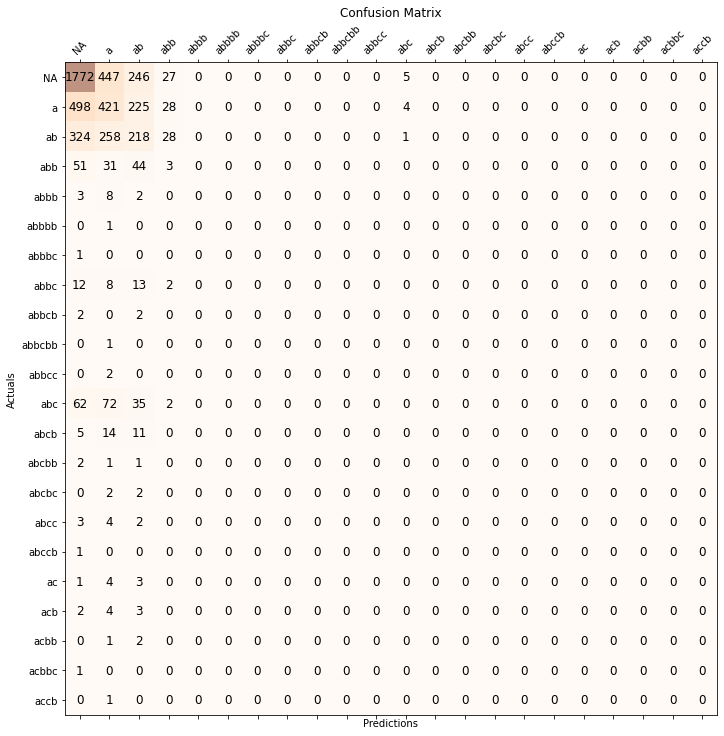

In [78]:
printConfusionMatrix(ann_list,extraction_list)

In [79]:
all_metrics = metrics.classification_report(ann_list, extraction_list, digits=3, zero_division=1)
print(all_metrics)

              precision    recall  f1-score   support

          NA      0.647     0.710     0.677      2497
           a      0.329     0.358     0.343      1176
          ab      0.269     0.263     0.266       829
         abb      0.033     0.023     0.027       129
        abbb      1.000     0.000     0.000        13
       abbbb      1.000     0.000     0.000         1
       abbbc      1.000     0.000     0.000         1
        abbc      1.000     0.000     0.000        35
       abbcb      1.000     0.000     0.000         4
      abbcbb      1.000     0.000     0.000         1
       abbcc      1.000     0.000     0.000         2
         abc      0.000     0.000     0.000       171
        abcb      1.000     0.000     0.000        30
       abcbb      1.000     0.000     0.000         4
       abcbc      1.000     0.000     0.000         4
        abcc      1.000     0.000     0.000         9
       abccb      1.000     0.000     0.000         1
          ac      1.000    

In [80]:
#### Merge label categories to only have {NA, a, ab, abc}

# ab+ -> ab
# ab+c -> abc
# ab+c+ -> abc
# ab+c+b+ -> abc
# ac+b+ -> abc
# ac -> ab

In [90]:
def merge_labels(label_list):
    '''This function merges label categories to only have {NA, a, ab, abc}'''
    merged_list = []
    pattern = r"(.)\1*"
    for label in label_list:
        res_label = re.sub(pattern, r"\1", label)
        if res_label == "NA":
            merged_list.append(res_label)
        elif res_label == "a":
            merged_list.append("a")
        elif res_label == "ac":
            merged_list.append("ab")
        elif set(["a", "b","c"]).issubset(set(res_label)):
            merged_list.append("abc")
        else:
            merged_list.append("ab")
    return merged_list

merged_ann = merge_labels(ann_list)
merged_extraction = merge_labels(extraction_list)

In [91]:
merged_ann

['ab',
 'a',
 'ab',
 'ab',
 'NA',
 'ab',
 'NA',
 'NA',
 'ab',
 'NA',
 'NA',
 'a',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'abc',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'a',
 'a',
 'ab',
 'NA',
 'ab',
 'NA',
 'ab',
 'a',
 'a',
 'a',
 'a',
 'ab',
 'abc',
 'NA',
 'a',
 'ab',
 'NA',
 'abc',
 'NA',
 'NA',
 'ab',
 'a',
 'NA',
 'a',
 'NA',
 'abc',
 'NA',
 'NA',
 'a',
 'a',
 'ab',
 'NA',
 'a',
 'ab',
 'ab',
 'NA',
 'NA',
 'a',
 'ab',
 'a',
 'NA',
 'NA',
 'ab',
 'NA',
 'a',
 'ab',
 'NA',
 'NA',
 'abc',
 'NA',
 'ab',
 'NA',
 'a',
 'ab',
 'a',
 'a',
 'ab',
 'a',
 'NA',
 'ab',
 'NA',
 'NA',
 'a',
 'ab',
 'NA',
 'ab',
 'ab',
 'NA',
 'ab',
 'NA',
 'ab',
 'ab',
 'a',
 'ab',
 'NA',
 'NA',
 'a',
 'NA',
 'abc',
 'NA',
 'NA',
 'a',
 'NA',
 'NA',
 'a',
 'a',
 'NA',
 'a',
 'NA',
 'NA',
 'NA',
 'NA',
 'ab',
 'NA',
 'NA',
 'ab',
 'NA',
 'NA',
 'ab',
 'NA',
 'a',
 'NA',
 'a',
 'ab',
 'NA',
 'NA',
 'a',
 'a',
 'a',
 'a',
 'a',
 'NA',
 'NA',
 'NA',
 'a',
 'NA',
 'ab',
 'NA',
 'a',
 'a',
 'a',
 'ab',
 'a',
 'NA'

In [105]:
len(merged_extraction)

4929

In [92]:
def merge_labels_loose(merged_list):
    '''This function merges label categories to only have {NA, a, ab, abc}'''
    loose_label = []
    for label in merged_list:
        if label == "NA":
            loose_label.append(label)
            continue
        elif label == "a":
            loose_label.append("open")
            continue
        else:
            loose_label.append("closed")

    return loose_label

merged_ann = merge_labels_loose(merged_ann)
merged_extraction = merge_labels_loose(merged_extraction)

In [103]:
len(merged_ann)

4929

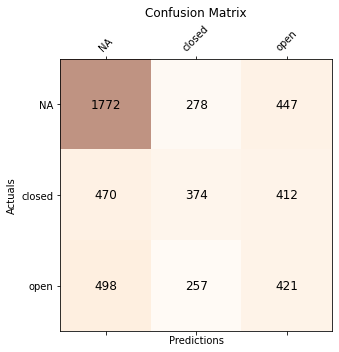

In [106]:
printConfusionMatrix(merged_ann,merged_extraction,f_size = 5)

In [108]:
overall = metrics.classification_report(merged_ann, merged_extraction, digits=3, zero_division=1)

In [109]:
print(overall)

              precision    recall  f1-score   support

          NA      0.647     0.710     0.677      2497
      closed      0.411     0.298     0.345      1256
        open      0.329     0.358     0.343      1176

    accuracy                          0.521      4929
   macro avg      0.462     0.455     0.455      4929
weighted avg      0.511     0.521     0.513      4929



In [ ]:
# Random_rate_occur = (number of A in the corpus) / (n*(n-1)(n-2)(1/27))

# Random_rate_AB = (A and B phases in the corpus) / ((n-1)*(1/9))

# Random_rate_ABC = (ABC in the corpus) / ((n-1)(n-2)(1/27))